<div style="text-align:center"><span style="color:balck; font-family:Times New Roman; font-size:3em;"> Tempus Takehome Assignment  </span></div>

<div style="text-align:left"><span style="color:blue; font-family:Times New Roman; font-size:2.5em;"> 1   Introduction </span></div>

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;"> The data of this assignment has 16,562 binary feature variables and 1 output variable (“response”). All the input features are anonymous. The goal of this assignment is to predict the "response" variable (0 or 1) based a broad spectrum of feature variables.  Through this assignment, I show data exploration and the choice of Machine Learning models that can be used to predict the "response" outcome with satisfying performance. I use the scikit-learn, pandas, numpy, seaborn and xgboost libraries in Python to complete this assignment. The code and the results are well-described in this Jupyter Notebook.
 </span></div>

In [86]:
import numpy as np
import pandas as pd
from pandas import DataFrame
#Print all rows and columns. Dont hide any
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import BaggingClassifier 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, recall_score
from itertools       import product
import warnings
warnings.filterwarnings("ignore")

<div style="text-align:left"><span style="color:blue; font-family:Times New Roman; font-size:2.5em;"> 2   Exploratory Analysis </span></div>

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;">The data is extracted from “takehome1.txt”. I load the tabular data file into a Pandas DataFrame by using the pandas.read_table function. I assign sep=\s+ to pandas.read_table since this data file uses whitespaces as the separator between columns. Because the datatype of all 16,563 variables in the file is int64, I use the dtype option in pandas.read_table to cast the values of the data to become int8, which can reduce memory usage of loading the data from 67.0 MB to 8.4 MB.  
 </span></div>

In [3]:
df=pd.read_table('takehome1.txt', sep='\s+', dtype=np.int8)
#df.head()

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;"> There are 530 observations with 16,563 binary variables in the dataset. There are no missing values existed in the data.     
 </span></div>

In [51]:
df.info()
print 'The number of missing values in the data : ',format (df.isnull().sum(axis=0).sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 530 entries, 0 to 529
Columns: 16563 entries, response to V16562
dtypes: int8(16563)
memory usage: 8.4 MB
The number of missing values in the data :  0


<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;"> For the output valuable “response”, 76.8% of the observations have the “response” value of 0 while only 23.2 % of the observations have the “response” value of 1. Therefore, the dataset doesn’t have approximately equal number of observations in each class, indicating a class imbalance.    
 </span></div>

In [4]:
df_responce=DataFrame(pd.value_counts(df["response"])).rename(columns={"response" : "Count"})
df_responce["Ratio"]=df_responce["Count"]/df_responce["Count"].sum(0)
df_responce

,Count,Ratio
0,407,0.767925
1,123,0.232075


<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;"> Among the 16,562 input binary variables, not all of them can provide predictive information to classify the “response” variable. There are 5669 one-level features and 10893 bi-level features. Almost one-third of input variables have one unique value, which means they fail to make a positive impact on model performance. Hence I delete the 5669 variables with only one level.
 </span></div>

In [5]:
df_nunique=df.ix[:,1:].apply(lambda x: x.nunique()).reset_index().rename(columns={"index":"feature", 0:"nunique"})
df_nunique["nunique"].value_counts().sort_index()

1     5669
2    10893
Name: nunique, dtype: int64

In [6]:
# I delete the variables with only one level from the data
one_level_features=df_nunique[df_nunique["nunique"]==1]['feature'].values
df=df.drop(one_level_features, axis=1)

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;"> Among the 10893 bi-level input variables, I find out there are 1350 variables that are identical to other variables by using the pandas duplicated function. These duplicated variables supply redundant information. I decide to delete them in order to reduce the computational complexity. After the process of data cleaning, I create a new DataFrame X as the input variables with 530 observations and 9543 feature variables. I also define Y as the output variable of “response”.
 </span></div>

In [7]:
print "The number of duplicated features : {}".format(df.ix[:,1:].T.duplicated().sum())
# Assign X is the input variables and Y is the output value of “response”.
X=df.ix[:,1:].T.drop_duplicates().T
Y=df["response"]
print "The number of the input feature variables after data cleaning : {} ".format(X.shape[1])

The number of duplicated features : 1350
The number of the input feature variables after data cleaning : 9543 


<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;"> Some of the feature variables show slim chance of making a real impact on the data modeling. For example, the figure below displays that there are 366, 836, 688, 512, and 451 bi-level features that only have 1, 2, 3, 4, and 5 times of occurrence of the value 1 from the 530 observations. In other words, almost 30% of binary features have less than or equal to 5 observations of showing the value 1. This indicates these features won’t provide significant information to predict the “response” outcome. The less informative features will be filtered out by using feature selection techniques. Lasso regularization and tree-based classifiers will be used to extract most important features from such a high-dimensional dataset. 
 </span></div>

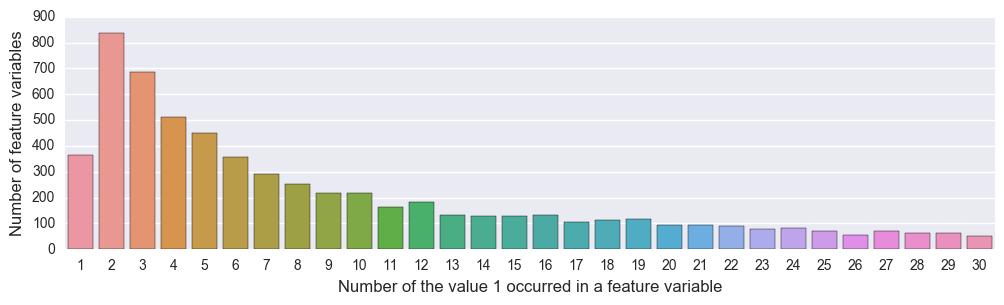

In [190]:
df_count_positivevalue=X.apply(lambda x :x.sum()).value_counts().sort_index()
plt.figure(figsize=(12,3))
sns.barplot(x=df_count_positivevalue[:30].index, y=df_count_positivevalue[:30].values)
plt.ylabel('Number of feature variables', fontsize=12)
plt.xlabel('Number of the value 1 occurred in a feature variable', fontsize=12)


<div style="text-align:left"><span style="color:blue; font-family:Times New Roman; font-size:2.5em;"> 3   Model Building </span></div>

<div style="text-align:left"><span style="color:blue; font-family:Times New Roman; font-size:2em;"> 3.1   Candidate Models </span></div>

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;">   Through the data exploration shown above, the data exhibits several characteristics: binary, high-dimensional, and imbalanced. For this classification problem, several Machine Learning models are applied and compared in order to achieve best predictive performance.<br \>
The Machine Learning models are selected below: 
<br \>
1.  Logistic Regression with regularization 
<br \>
2.	Random Forest Classifier 
<br \>
3.	Extra Trees Classifier
<br \>
4.	Bagging Classifier 
<br \>
5.  AdaBoost Classifier 
<br \>
6.  Gradient Boosting Classifier
<br \>
7. XGB Classifier
<br \>

Logistic regression is a pretty simple and easily interpreted classification algorithm that can perform feature selection to avoid overfitting by using l2 or l1 regularization. A simple regularized Logistic Regression is served as a baseline to show the predictive power of the input data on the output variable. The tree ensemble algorithms have been known to perform very well on high dimensional and imbalanced datasets. The tree-based classifiers apply the splitting rules that will address both class labels and discard irrelevant features for each node split.

 </span></div>

<div style="text-align:left"><span style="color:blue; font-family:Times New Roman; font-size:2em;"> 3.2   Train Test Split </span></div>

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;">In order to evaluate final model’s generalized performance on an unseen dataset, the preprocessed data of X and Y are split into the training (80%) and test (20%) datasets. Because of the class imbalance, stratified sampling is applied in the split to preserve the same percentage for each target class as in the complete set.
The test set (X_test, Y_test) is used to evaluate the performance of the final model on unseen data after hyperparameter tuning of a classifier. The training set (X_train, Y_train) is used to build learning algorithms and tune hyperparameters. 
 

 </span></div>

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)

<div style="text-align:left"><span style="color:blue; font-family:Times New Roman; font-size:2em;"> 3.3   Cross Validation =>  Hyper-parameters Tuning => Model Evaluation </span></div>

<div style="text-align:left"><span style="color:blue; font-family:Times New Roman; font-size:1.8em;"> 3.3.1   Before Feature Engineering </span></div>

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;">I use 4-fold stratified cross validation to tune the hyper-parameters of each candidate classifier in order to optimize the classification accuracy. The GridSearchCV in scikit-learn is applied to divide the training data into the train set and validation set. 4-fold Cross Validation creates 4 different combination of train/validation sets. The train set is used to train the model and the validation set is for prediction error estimation. A model with best parameters will be selected by the validation set with maximum prediction accuracy and will be assessed by the test set to estimate generalization error of this selection.
 </span></div>

In [51]:
def model_tuning(classifier, param_grid, X_train, X_test, Y_train, Y_test, valid_score_list, test_score_list):
    grid = GridSearchCV(classifier,param_grid, scoring='accuracy', n_jobs=-1, cv=4)
    grid.fit(X_train, Y_train)
    valid_score_list.append(grid.best_score_)
    test_score_list.append(grid.score(X_test,Y_test))
valid_score_list=[]
test_score_list=[]
############
############ 1. Logistic Regression with regularization
classifier = LogisticRegression(random_state=0)
param_grid = {'C': [0.1],'penalty': ['l1','l2']}
model_tuning(classifier, param_grid, X_train, X_test, Y_train, Y_test, valid_score_list, test_score_list)
############
############ 2. Random Forest Classifier 
classifier = RandomForestClassifier(criterion='entropy', random_state=0, class_weight = "balanced")
param_grid = {'n_estimators': [200],
              'max_depth': [6],
              'min_samples_split': [22],
              'min_samples_leaf': [4]}
model_tuning(classifier, param_grid, X_train, X_test, Y_train, Y_test, valid_score_list, test_score_list)
############
############ 3. Bagging Classifier
base_estimator = DecisionTreeClassifier(criterion='entropy',max_depth=None, random_state=0)
classifier = BaggingClassifier(base_estimator=base_estimator, bootstrap=True, bootstrap_features=True, 
                               n_jobs=-1, random_state=0)
param_grid = {'n_estimators': [20],
              'max_samples': [0.3]}
model_tuning(classifier, param_grid, X_train, X_test, Y_train, Y_test, valid_score_list, test_score_list)
############
############ 4. AdaBoost Classifier 
base_estimator = DecisionTreeClassifier(criterion='entropy',max_depth=1, random_state=0, class_weight="balanced")
classifier = AdaBoostClassifier(base_estimator=base_estimator, random_state=0)
param_grid = {'n_estimators': [4],
              'learning_rate': [0.1]}
model_tuning(classifier, param_grid, X_train, X_test, Y_train, Y_test, valid_score_list, test_score_list)
############
############ 5. Gradient Boosting Classifier
classifier = GradientBoostingClassifier(random_state=0,learning_rate=0.1)
param_grid = {'n_estimators': [6],
              'max_depth': [2],
              'subsample': [1],
              'min_samples_leaf': [3]}
model_tuning(classifier, param_grid, X_train, X_test, Y_train, Y_test, valid_score_list, test_score_list)
############
############ 6. XGB Classifier 
classifier = XGBClassifier(objective='binary:logistic', seed =0, subsample=1.0,
                          colsample_bytree=1.0,min_child_weight=1,learning_rate=0.1)
param_grid = {'n_estimators': [60],
              'max_depth': [4]}
model_tuning(classifier, param_grid, X_train, X_test, Y_train, Y_test, valid_score_list, test_score_list)
classifiers=["Logistic Regression", "Random Forest Classifier", 
            "Bagging Classifier", "AdaBoost Classifier", "Gradient Boosting Classifier", "XGB Classifier" ]
DataFrame({"Classifier":classifiers, "Accuracy in validation set" : valid_score_list,
           "Accuracy in test set" : test_score_list}, columns=["Classifier","Accuracy in validation set","Accuracy in test set"])

,Classifier,Accuracy in validation set,Accuracy in test set
0,Logistic Regression,0.898585,0.820755
1,Random Forest Classifier,0.900943,0.830189
2,Bagging Classifier,0.903302,0.820755
3,AdaBoost Classifier,0.900943,0.820755
4,Gradient Boosting Classifier,0.905660,0.839623
5,XGB Classifier,0.903302,0.820755


<div style="text-align:left"><span style="color:blue; font-family:Times New Roman; font-size:1.8em;"> 3.3.2   Apply Feature Engineering </span></div>

In [23]:
classifier = XGBClassifier(objective='binary:logistic', seed =0, subsample=1.0,
                          colsample_bytree=1.0,min_child_weight=1,learning_rate=0.1,
                          n_estimators=60,max_depth=4)
classifier.fit(X_train, Y_train)
thresholds = np.sort(classifier.feature_importances_)
thresholds=np.unique(thresholds)
feature_numbers=[]
valid_score_list=[]
test_score_list=[]
for thresh in thresholds[1:]:
    # select features using threshold
    selection = SelectFromModel(classifier, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    select_X_test = selection.transform(X_test)
    # train model
    classifier1 = XGBClassifier(objective='binary:logistic', seed =0, subsample=1.0,
                          colsample_bytree=1.0,min_child_weight=1,learning_rate=0.1)
    param_grid = {'n_estimators': [40,50,60,70,80,90,100,120,140,160,180,200,250,300,350,400],
                  'max_depth': [2,3,4,5],
                  'min_child_weight': [1,2,3,4]}
    grid = GridSearchCV(classifier,param_grid, scoring='accuracy', n_jobs=-1, cv=4)
    grid.fit(select_X_train, Y_train)
    feature_numbers.append(select_X_train.shape[1])
    valid_score_list.append(grid.best_score_)
    test_score_list.append(grid.score(select_X_test,Y_test))
    
DataFrame({"Threshold":thresholds, "Feature numbers" :feature_numbers,
           "Accuracy in validation set" : valid_score_list, "Accuracy in test set" : test_score_list}, 
          columns=["Threshold","Feature numbers",
                   "Accuracy in validation set","Accuracy in test set"])

,Threshold,Feature numbers,Accuracy in validation set,Accuracy in test set
0,0.000000,9543,0.903302,0.820755
1,0.002070,248,0.917453,0.830189
2,0.004141,79,0.917453,0.820755
3,0.006211,47,0.933962,0.811321
4,0.008282,25,0.931604,0.801887
5,0.010352,16,0.919811,0.811321
6,0.012422,12,0.917453,0.801887
7,0.014493,7,0.910377,0.773585
8,0.016563,6,0.908019,0.820755
9,0.020704,5,0.905660,0.820755


In [9]:
classifier = XGBClassifier(objective='binary:logistic', seed =0, subsample=1.0,
                          colsample_bytree=1.0,min_child_weight=1,learning_rate=0.1,
                          n_estimators=60,max_depth=4)
classifier.fit(X_train, Y_train)
# Delete non-important features
thresh=0.002070
selection = SelectFromModel(classifier, threshold=thresh, prefit=True)
select_X_train = selection.transform(X_train)
select_X_test = selection.transform(X_test)

<div style="text-align:left"><span style="color:blue; font-family:Times New Roman; font-size:1.8em;"> 3.3.3   After Feature Engineering </span></div>

In [50]:
def model_tuning(classifier, param_grid, X_train, X_test, Y_train, Y_test, valid_score_list, test_score_list):
    grid = GridSearchCV(classifier,param_grid, scoring='accuracy', n_jobs=-1, cv=4)
    grid.fit(X_train, Y_train)
    valid_score_list.append(grid.best_score_)
    test_score_list.append(grid.score(X_test,Y_test))
valid_score_list=[]
test_score_list=[]
############
############ 1. Logistic Regression with regularization
classifier = LogisticRegression(random_state=0)
param_grid = {'C': [0.1],'penalty': ['l2']}
model_tuning(classifier, param_grid, select_X_train, select_X_test, Y_train, Y_test, valid_score_list, test_score_list)
############
############ 2. Random Forest Classifier 
classifier = RandomForestClassifier(criterion='entropy', random_state=0, class_weight = "balanced")
param_grid = {'n_estimators': [40],
              'max_depth': [10],
              'min_samples_split': [2],
              'min_samples_leaf': [2]}
model_tuning(classifier, param_grid, select_X_train, select_X_test, Y_train, Y_test, valid_score_list, test_score_list)
############
############ 3. Bagging Classifier
base_estimator = DecisionTreeClassifier(criterion='entropy',max_depth=None, random_state=0)
classifier = BaggingClassifier(base_estimator=base_estimator, bootstrap=True, bootstrap_features=True, 
                               n_jobs=-1, random_state=0)
param_grid = {'n_estimators': [10],
              'max_samples': [0.9]}
model_tuning(classifier, param_grid, select_X_train, select_X_test, Y_train, Y_test, valid_score_list, test_score_list)
############
############ 4. AdaBoost Classifier 
base_estimator = DecisionTreeClassifier(criterion='entropy',max_depth=1, random_state=0, class_weight="balanced")
classifier = AdaBoostClassifier(base_estimator=base_estimator, random_state=0)
param_grid = {'n_estimators': [5],
              'learning_rate': [0.01]}
model_tuning(classifier, param_grid, select_X_train, select_X_test, Y_train, Y_test, valid_score_list, test_score_list)
############
############ 5.Gradient Boosting Classifier
classifier = GradientBoostingClassifier(random_state=0,learning_rate=0.1)
param_grid = {'n_estimators': [220],
              'max_depth': [4],
              'subsample': [0.2],
              'min_samples_leaf': [9]}
model_tuning(classifier, param_grid, select_X_train, select_X_test, Y_train, Y_test, valid_score_list, test_score_list)
############
############ 6.XGB Classifier 
classifier = XGBClassifier(objective='binary:logistic',
                          colsample_bytree=1.0,min_child_weight=1,learning_rate=0.1, nthread=-1,seed=0)
param_grid = {'n_estimators': [660],
              'max_depth': [2],
              'subsample':[0.5]}
model_tuning(classifier, param_grid, select_X_train, select_X_test, Y_train, Y_test, valid_score_list, test_score_list)
classifiers=["Logistic Regression", "Random Forest Classifier", 
            "Bagging Classifier", "AdaBoost Classifier", "Gradient Boosting Classifier", "XGB Classifier" ]
DataFrame({"Classifier":classifiers, "Accuracy in validation set" : valid_score_list,
           "Accuracy in test set" : test_score_list}, columns=["Classifier","Accuracy in validation set","Accuracy in test set"])

,Classifier,Accuracy in validation set,Accuracy in test set
0,Logistic Regression,0.919811,0.849057
1,Random Forest Classifier,0.910377,0.849057
2,Bagging Classifier,0.908019,0.830189
3,AdaBoost Classifier,0.900943,0.820755
4,Gradient Boosting Classifier,0.933962,0.849057
5,XGB Classifier,0.924528,0.849057


<div style="text-align:left"><span style="color:blue; font-family:Times New Roman; font-size:1.8em;"> 3.3.4   Best Model Performance </span></div>

In [87]:
classifier = GradientBoostingClassifier(random_state=0,learning_rate=0.1,
                                       n_estimators=220,max_depth=4,subsample=0.2,min_samples_leaf=9 )
classifier.fit(select_X_train, Y_train)
Y_pred=classifier.predict(select_X_test) 
DataFrame([accuracy_score(Y_test, Y_pred),precision_score(Y_test, Y_pred),recall_score(Y_test, Y_pred)],
          index=["Accuracy","Precision","Recall"]).rename(columns={0:"Score"})

,Score
Accuracy,0.849057
Precision,0.846154
Recall,0.440000


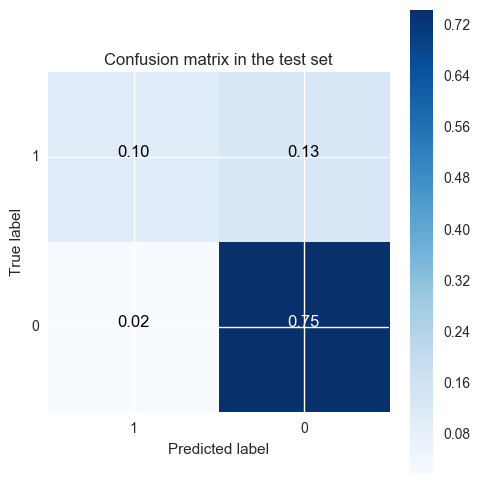

In [84]:
c=confusion_matrix(Y_test, Y_pred, labels=[1, 0])
np.set_printoptions(precision=5)
c=c.astype('float')/c.sum()

plt.figure(figsize=(5,5))
plt.imshow(c, interpolation='nearest',cmap=plt.cm.Blues)
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['1', '0'])
plt.yticks(tick_marks, ['1', '0'])
plt.colorbar()
thresh = c.max() / 2.
for i, j in product(range(c.shape[0]), range(c.shape[1])):
    plt.text(j, i, '%.2f' % c[i, j],horizontalalignment="center",
             color="white" if c[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion matrix in the test set')